In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as plotly_express
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

In [3]:
#load the data

curr_dir=os.getcwd()
f_path = os.path.join(curr_dir, "data", "cancer patient data sets.csv")

df=pd.read_csv(f_path)
df['Level_hot_encode'] = df['Level'].apply(lambda x: ["Low", "Medium", "High"].index(x))
features = df.drop(["index","Patient Id","Level"], axis=1)


In [4]:
# final selected features from feature selection (method2b)
final_features_method2b = ['Age',
 'Alcohol use',
 'Smoking',
 'chronic Lung Disease',
 'Fatigue',
 'Coughing of Blood',
 'Chest Pain',
 'Genetic Risk',
 'OccuPational Hazards',
 'Shortness of Breath',
 'Weight Loss',
 'Clubbing of Finger Nails',
 'Dry Cough',
 'Wheezing']


### Proving linear separability of our dataset (Method 1: PCA)
We attempt to prove that a linear model is sufficient to predict our class labels using prinicipal component analysis (PCA)
- Attempt 1: Prove linear separability using the whole feature set 

- Attempt 2: Prove linear separability using selected features from method 2b

#### Define functions 
- pca_tranform performs PCA on a feature set (x), where n_comp is the number of principal components to keep. This means that n_comp is the number of dimensions that we would like to reduce the feature space to. We also append the class labels for ease of visualisation.

- plot_PCA_2D and plot_PCA_3D takes in the output of pca_transform and plots 1. PC1 against PC2 and 2. PC1 against PC2 against PC3 respectively (for all datapoints). Additionally, each datapoint is colored with its class label to observe the class separation (if any).


In [5]:
def pca_transform(x, y, n_comp):
  pc_list = [f"PC{i+1}" for i in range(n_comp)]
  pca = decomposition.PCA(n_components=n_comp)
  pc = pca.fit_transform(x)
  pc_df = pd.DataFrame(data=pc,columns=pc_list)
  pc_df['Label'] = y
  return pc_df, pca, pc_list

def plot_PCA_2D(pc_df, pca, pc_list):
    var = pd.DataFrame({'Variance':pca.explained_variance_ratio_,
                'PC':pc_list})

    ax = sns.barplot(x='PC',y="Variance", data=var)
    print(ax.containers[0])
    ax.bar_label(ax.containers[0],fmt='%.2f')

    sns.lmplot( x="PC1", y="PC2",
    data=pc_df, 
    fit_reg=False, 
    hue='Label', 
    legend=True,
    scatter_kws={"s": 80})

def plot_PCA_3D(pc_df, pca):
    pca_var_sum=sum(pca.explained_variance_ratio_[:4])
    figure = plotly_express.scatter_3d(pc_df,x="PC1",y="PC2",z="PC3",color="Label")
    figure.update_layout(showlegend=True)
    figure.show()

#### Attempt 1: All features 
- First, we observe the overall PCA separation of all datapoints. Based on the barplot, we observe that the principal components PC1, PC2, and PC3 explains 60%, 18%, and 6% of the total variance in the original dataset.

- From the 2D PCA plot, we observe that datapoints with "Low" label is clearly separated from datapoints with "High" label. However, we observe that some datapoints with "Medium" labels overlap with those with either "Low" or "High" labels. This suggest that PC1 and PC2 are less unable to discern "Medium" labels from "Low" and "High" labels. This observation is also apparent in the 3D plot shown below.

<BarContainer object of 5 artists>


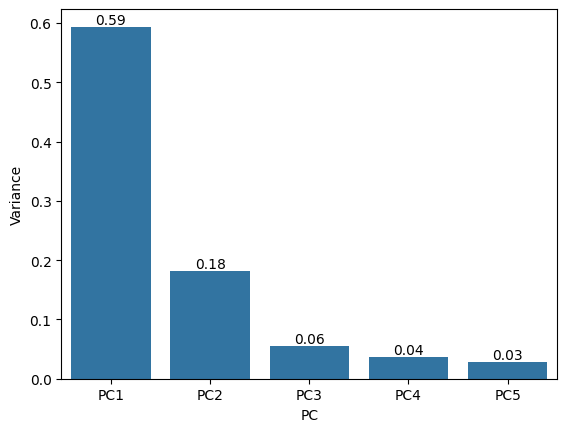

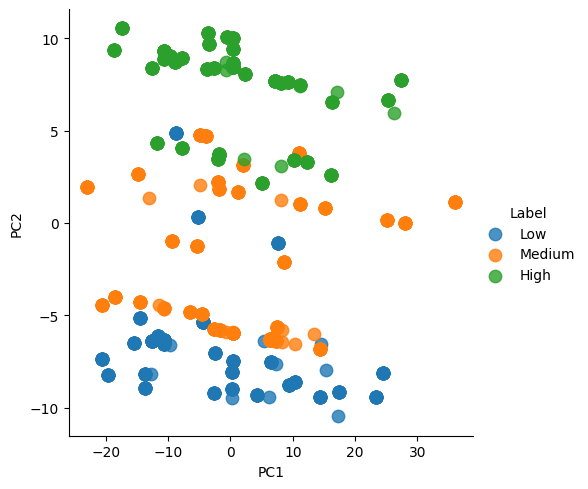

In [6]:
n_comp=5
y=df["Level"]
pc_df, pca, pc_list= pca_transform(features, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

In [7]:
plot_PCA_3D(pc_df, pca)

##### Attempt to prove pairwise separability of labels 
- Since "Low" and "High" labels are clearly linear separable, it remains to prove that ("Low" and "Medium") and ("Medium" and "High") labels are linear separable as well. 

- Method: Remove one of the class labels. For example, remove "High" label to check linear separability of "Low" and "Medium" labels only. 

- Results: We observe that in both cases, removing one of the class labels resulted in worse separation by PCA, where the linear boundary is non-existent. This suggest that the datapoints from the removed class play an important role in the model's ability to accurately predict all class labels. When we remove one of the classes, we are discarding around 30% of our dataset which essentially decreases the variability of the set. Since PCA aims to maximise variance, the overall decrease in variability of our dataset may have hindered the ability of PCA to identify principal components that separate our data. 

##### Low vs High

<BarContainer object of 5 artists>


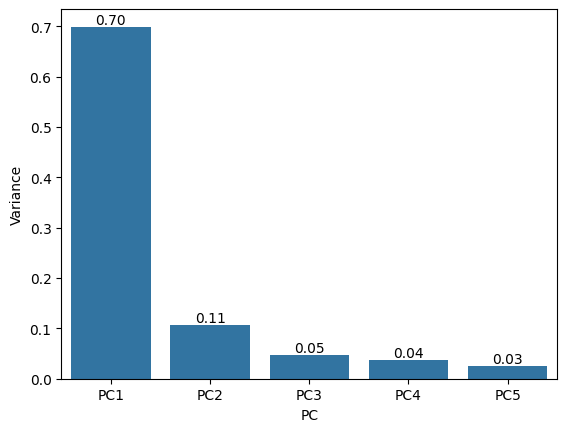

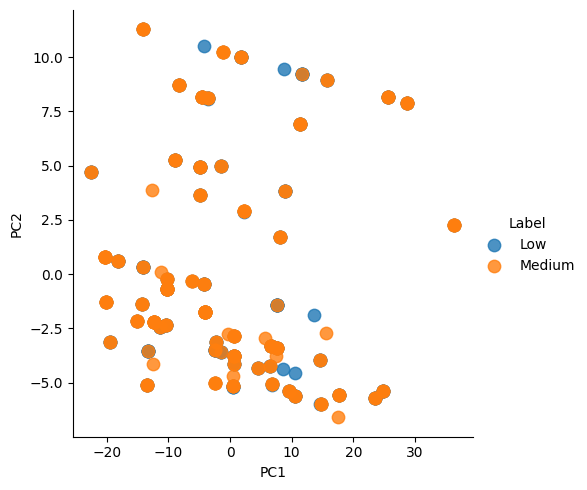

In [8]:
df_low_medium = df.loc[df["Level"].isin(["Low","Medium"])]
x=df_low_medium.drop(["index","Patient Id","Level"], axis=1)
x=x[features.columns]
y=df_low_medium["Level"]
n_comp=5
pc_df, pca, pc_list= pca_transform(x, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

In [9]:
plot_PCA_3D(pc_df, pca)

##### Medium vs High

<BarContainer object of 5 artists>


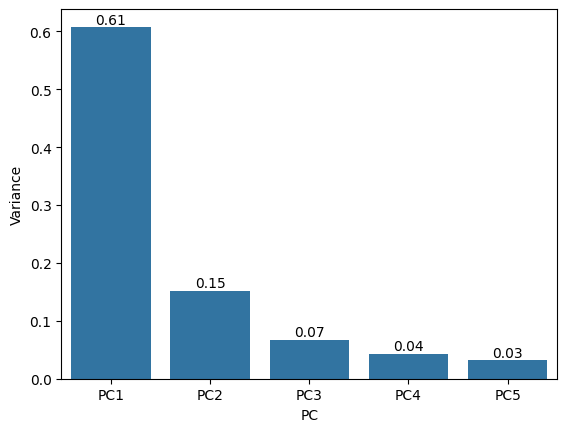

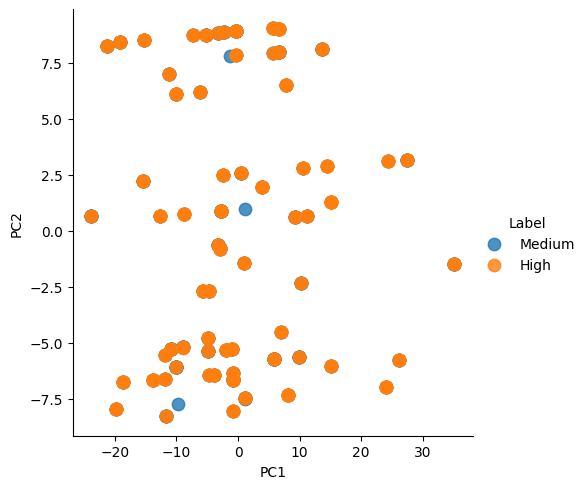

In [10]:
df_medium_high = df.loc[df["Level"].isin(["Medium","High"])]
x=df_medium_high.drop(["index","Patient Id","Level"], axis=1)
x=x[features.columns]
y=df_medium_high["Level"]
n_comp=5
pc_list = [f"PC{i+1}" for i in range(n_comp)]
pc_df, pca, pc_list= pca_transform(x, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

In [11]:
plot_PCA_3D(pc_df, pca)

#### Attempt 2: Selected features
- We observe that the overall PCA results are similar to that of attempt 1. 

<BarContainer object of 5 artists>


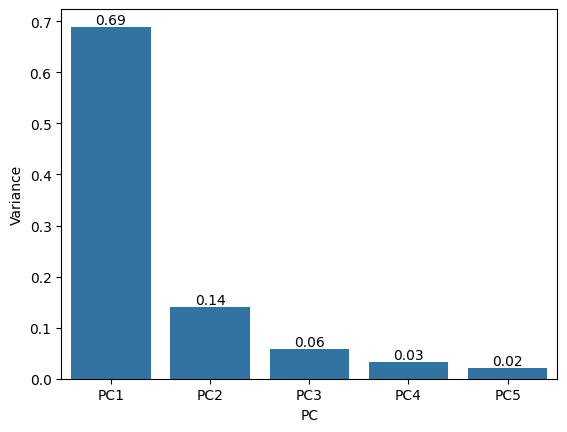

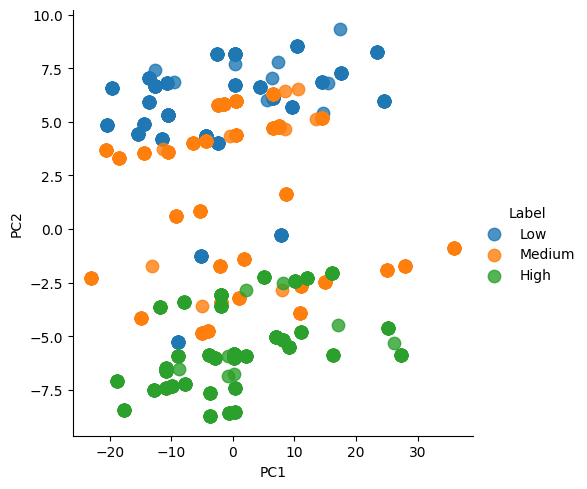

In [12]:
n_comp=5
x = features[final_features_method2b]
y = df["Level"]
pc_df, pca, pc_list= pca_transform(x, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

### Proving linear separability of our dataset (Method 2: LDA)
- Since PCA did not seem to adequately prove linear separability of our dataset, we moved on to try Linear Discriminant Analysis (LDA). 

- PCA is an unsupervised method which aims to capture the direction of maximum variance in the data. On the other hand, LDA is a supervised method which aims to find the projection that maximises class separability while minimising the variance within each class. Hence, LDA cound better identify the linear boundary between classes. 

#### Define functions
- The custom LDA function can be broken down into 3 main parts. First, we used scikit-learn library's LinearDiscriminantAnalysis model to fit and transform our training dataset. Second, we extract the explained and cumulative variance ratio from the linear discriminants. The explained variance ratio descibes the variance captured by each linear discriminant while the cumulative variance ratio describes the accumulation of variance for each linear discriminant. Since we have 3 classes, the maximum number of linear discriminants that we can find is 2 (max linear discriminants = no. of class labels - 1). Last, we plot the cumulative explained variance against the number of linear discriminants to understand the amount of variance in the dataset that is captured by LDA.

- The custom SVM function can be broken down into 2 main parts. First, 

In [13]:
def LDA(X_train, X_test,y_train):
    # Fit and transform 
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    # Cumulative variance + explained variance 
    explained_var_ratio=lda.explained_variance_ratio_
    cumulative_var_ratio=np.cumsum(explained_var_ratio)
    lda_df = pd.DataFrame()
    lda_df['Cumulative Variance Ratio'] = cumulative_var_ratio
    lda_df['Explained Variance Ratio'] = explained_var_ratio
    display(lda_df)
    # Plot 
    sns.set(style='whitegrid')
    plt.plot(cumulative_var_ratio)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    return X_train_lda, X_test_lda

def SVM(X_train_lda,X_test_lda, y_train,y_test):
    linear_clf = svm.SVC(kernel="linear", decision_function_shape='ovo', probability=True)
    linear_clf.fit(X_train_lda, y_train)
    y_pred = linear_clf.predict(X_test_lda)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)

    # Training results 
    X_set, y_set = X_train_lda, y_train

    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                        np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    X1 = np.array(X1, dtype=float)
    X2 = np.array(X2, dtype=float)
    input_array = np.column_stack((X1.ravel(), X2.ravel()))
    Z = linear_clf.predict(input_array)
    Z = Z.reshape(X1.shape)
    Z = np.array(Z, dtype=float)

    fig, ax = plt.subplots(1,2,figsize=(12,6))
    
    ax[0].contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green', 'blue')))
    ax[0].set_xlim(X1.min(), X1.max())
    ax[0].set_ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        label = df[df["Level_hot_encode"]==j].iloc[0]["Level"]
        ax[0].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green', 'blue'))(i), label = label)
    ax[0].set_title('SVC (Training set)')
    ax[0].set_xlabel('LD1')
    ax[0].set_ylabel('LD2')

    # Testing results 
    X_set, y_set = X_test_lda, y_test

    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                        np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    X1 = np.array(X1, dtype=float)
    X2 = np.array(X2, dtype=float)
    input_array = np.column_stack((X1.ravel(), X2.ravel()))
    Z = linear_clf.predict(input_array)
    Z = Z.reshape(X1.shape)
    Z = np.array(Z, dtype=float)
    
    ax[1].contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green', 'blue')))
    ax[1].set_xlim(X1.min(), X1.max())
    ax[1].set_ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        label = df[df["Level_hot_encode"]==j].iloc[0]["Level"]
        ax[1].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green', 'blue'))(i), label = label)
    ax[1].set_title('SVC (Testing set)')
    ax[1].set_xlabel('LD1')
    ax[1].set_ylabel('LD2')
    plt.legend()
    plt.show()
    

#### Attempt 1: All features
- We observe that the explained variance ratio of LD1 and LD2 are 88% and 12% respectively. Further, the cumulative variance ratio of LD1+LD2 is 100%. This suggest that LD1 and LD2 are able to capture all the variance in the dataset.

- From the SVC plots, we see that clusters form based on their class label with a clear linear boundary between each class label. However, we see that some datapoints with label "Low" are falsely predicted to be of "Medium" label, which also explains the slightly lower model accuracy of 97%. The lower model accuracy may be attributed to the high number of features (i.e. curse of dimensionality), leading to lower model performance.

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.881365,0.881365
1,1.000000,0.118635


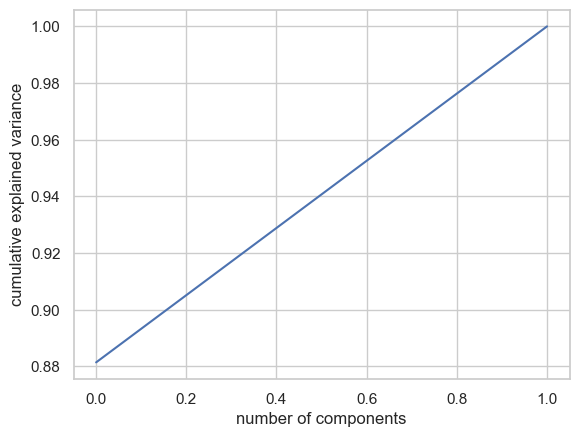

In [14]:
x = features
y = df["Level_hot_encode"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train_lda, X_test_lda = LDA(X_train, X_test, y_train)

Accuracy:  0.97


/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_50939/2527522587.py:48: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_50939/2527522587.py:71: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



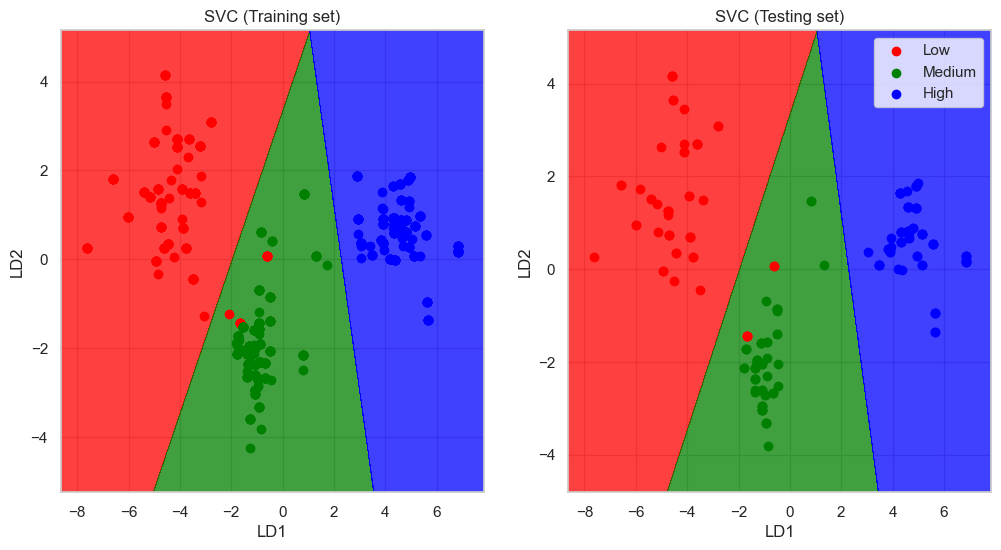

In [15]:
SVM(X_train_lda,X_test_lda, y_train,y_test)

#### Attempt 2: Selected features 
The curse of dimensionality happens when we have too many features but insufficient data to accurately generalise a model. In our case, we have 23 features but only 1000 datapoints, which may result in lower model performance. Further, a large number of features may add irrelevant information, increasing the signal-to-noise ratio. Hence, it is impactful to observe whether using a selected set of features could improve the results of linear separability of our data. 

- We observe that the explained variance ratio of LD1 and LD2 are 93% and 6% respectively. Compared to attempt 1, LDA1 (attempt 2) explains more variance of the data, suggesting that feature extraction does help to improve the model's ability to learn the features of the data. Similarly, we observe a cumulative variance ratio of 100%.

- From the SVC plots, we see that clusters form based on their class label with a clear linear boundary between each class label. Compared to attempt 1, we observe less datapoints with "Low" label that are wrongly predicted as "Medium". This is further supported by a higher model accuracy of 99%. 

- Overall, we can conclude that the selected features are not only sufficient to prove linear separability of our data but also help improve the training of the model.

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.937679,0.937679
1,1.000000,0.062321


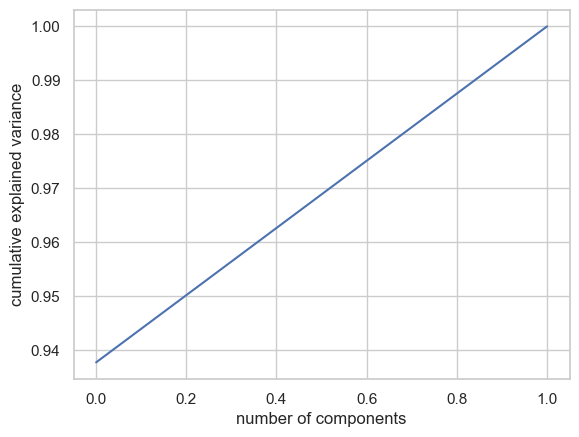

In [16]:
x = features[final_features_method2b]
y = df["Level_hot_encode"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train_lda, X_test_lda = LDA(X_train, X_test, y_train)

Accuracy:  0.99


/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_50939/2527522587.py:48: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_50939/2527522587.py:71: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



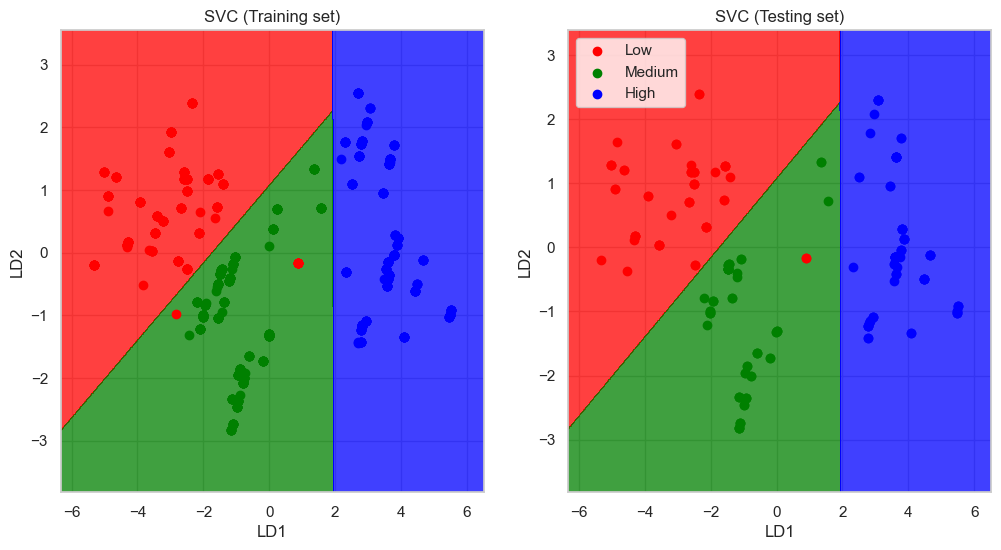

In [17]:
SVM(X_train_lda,X_test_lda, y_train,y_test)